In [3]:
import sys; sys.path.insert(0, '..')

import gym
import sys
import torch
import tester
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Javascript

import pytorch_drl.models.ddpg_models as models
from pytorch_drl.utils.exploration import *
from pytorch_drl.algs.ddpg import DDPG

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")#
#device = "cpu"
print("Device:", device)


Device: cuda:0


## 1. Define Utils:

### 1.1 Plotting:

In [43]:
def mean_filter(arr, filter_len):
    arr = np.concatenate([[arr[0]]*(filter_len-1), arr])
    filter_arr = np.ones(filter_len)/filter_len
    arr = arr
    output = list()
    for i in range(filter_len-1, len(arr)):
        conv = np.sum(filter_arr * arr[i-filter_len+1:i+1])
        output.append(conv)
    return output

def plot(scores, n=None):
    if n is not None:
        scores = mean_filter(scores, n)
    clear_output(True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode')
    plt.show()

## 2. Create environment

In [6]:
env_name = "Pendulum-v0"
env = gym.make(env_name)
env.seed(0)

state_size =  env.observation_space.shape[0]
action_size = env.action_space.shape[0]

print("State size:", state_size, "\nAction size:", action_size)
print(env.action_space.high, env.action_space.low)

/home/selo/Envs/ml-agent_/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


State size: 3 
Action size: 1
[2.] [-2.]


## 3. Define networks for different algorithms

In [7]:
def copy_network(network1, network2):
    network2.load_state_dict(network1.state_dict())

In [8]:
max_t = 1000
n_episodes = 2_000
seed = 0

## 4. DDPG Test

Test the standard DDPG algorithm

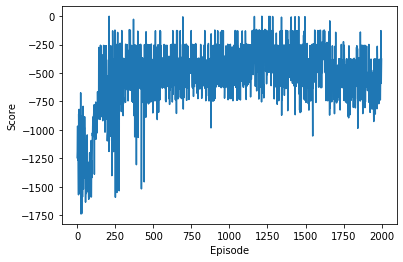

In [47]:
value_net1 = models.DDPGValueNetwork(state_size, action_size)
value_net2 = models.DDPGValueNetwork(state_size, action_size)
copy_network(value_net1, value_net2)

pol_net1 = models.DDPGPolicyNetwork(state_size, action_size)
pol_net2 = models.DDPGPolicyNetwork(state_size, action_size)
copy_network(pol_net1, pol_net2)

max_act = env.action_space.high
min_act = env.action_space.low

noise_proc = OrnsteinUhlenbeck(x_size=env.action_space.shape, mu=0, 
                sigma_init=0.3, sigma_final=0.3, 
                sigma_horizon=1)

action = env.action_space.sample()
#noise_proc = OrnsteinUhlenbeck(x0=np.zeros_like(action))

lr_val = 1e-3
lr_pol = 1e-4

# init agent:
agent = DDPG(seed=seed,
             prioritized_replay=False,
             is_beta=0.6,
             pr_alpha=0.2,   
             beta_horz = 20000,
             n=3, #n-step
             nstep=False,
             gamma = 0.99,
             lr_val=lr_val,
             lr_pol=lr_pol,
             buf_size = int(1e6),
             batch_size = 64,
             tau = 1e-3,
             device = device,
             policy_net=pol_net1, 
             policy_net_target=pol_net2,
             value_net=value_net1,
             value_net_target=value_net2,
             min_act=min_act,
             max_act=max_act,
             warm_up=1e4,
             noise_process=noise_proc
            )

# train the agent
scores = tester.train_agent(agent, env, max_t, n_episodes,
                            "ddpg", render_freq=1000, log=True, max_score=-20, test_freq=20)
# plot the training:
plot(scores)

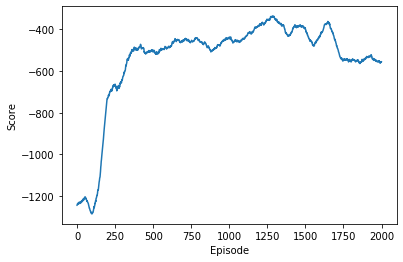

In [50]:
plot(scores, 100)

### 4.1 Trained Agent Demonstration

In [ ]:
tester.test_agent(agent, env, max_t, render=True, num_of_episodes=5, log=True)

### 4.2 Bipedal Test

## 4. DDPG - Rainbow Test

#### DDPG with:
- Prioritized experience replay
- Noisy networks
- Quantile regression
- N-step returns